<a href="https://colab.research.google.com/github/dokeyuka/deep-learning-practice/blob/main/DL_practice10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN




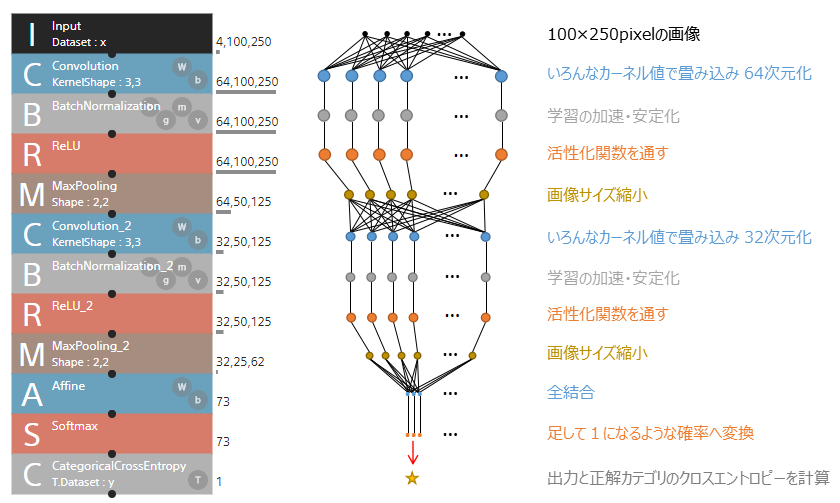
## Convolution layerとPooling layer
## ・全結合層の問題点：データの形状が無視される(すべての入力データを1次元データに直す)
## ・Convolution layer：画像なら3次元データをそのまま3次元として入出力
## 畳み込み演算、入力データに対してfilterのウィンドウを一定の間隔でスライドさせながら積和演算
## →filter適用後バイアス項を加算
### 特徴マップ：畳み込み層の入出力データ
### 入力特徴マップ、出力特徴マップ

---



# 全体構造
## (conv,ReLU,pooling)→(conv,ReLU,pooling)→(conv,ReLU)→(Linear,ReLU)→(Linear)→(Softmax) 

# padding:P
## 入力データの周囲に固定のデータを埋めることで出力サイズを調整する
## padding大→出力大
# stride:S
## フィルターを適用する位置の間隔
## stride 大→出力小
# 入力サイズ(H,W)、フィルターサイズ(FH, FW)、出力サイズ(OH,OW)
## OH = (H + 2P - FH)/S + 1
## OW = (W + 2P - FW)/S + 1


In [1]:
gpu_info = !nvidia-smi -L
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

GPU 0: Tesla T4 (UUID: GPU-d6d53e13-ef2f-0a41-d3e9-127286cd53df)


In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import os
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn 
import torch.optim as optimizers
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
'''
  (1) modelの実装
'''

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.conv2 = nn.Conv2d(128, 256, 3)

        self.fc1 = nn.Linear(256 * 5 * 5, 150)
        self.fc2 = nn.Linear(150, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = x.view(-1,256 * 5 * 5)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(self.fc3(x),dim=1)
        return x

net = Net()
print(net)

class EarlyStopping:
  def __init__(self, patience = 0, verbose = 0):
    #self._step 連続で最小値を上回ったepoch数を保持
    self._step = 0
    #self._loss 誤差の最小値を保持
    self._loss = float('inf')
    self.patience = patience
    self.verbose = verbose
  
  def __call__(self, loss):
    if self._loss < loss:
      self._step += 1
      if self._step > self.patience:
        if self.verbose:
          print('early stopping')
          return True
    else:
        self._step = 0
        self._loss = loss
    return False  



if __name__ == '__main__':
  np.random.seed(123)
  #torch用の乱数シード
  torch.manual_seed(123)

  #deviceに実行環境を格納して同じコードでCPUでもGPUでも対応できるように
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
'''
  1 データの準備
'''

data = MNIST(root="./MNIST", train=True, download=True, transform=transforms.ToTensor())
data_loader = DataLoader(data, batch_size=64, shuffle=True)
train_data = MNIST(root="./MNIST", train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(root="./MNIST", train=False, download=True, transform=transforms.ToTensor())

n_samples = len(train_data)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
#2番目の引数 = 分割するデータ数
#8:2に分割して検証データを作る
mnist_train, mnist_val = random_split(train_data, [n_train, n_val])
test_dataloader = DataLoader(test_data,
                             batch_size = 16,
                             shuffle = False)
val_dataloader = DataLoader(test_data,
                            batch_size = 16,
                            shuffle = False)


'''
  2 モデルの構築
'''
model = Net().to(device)

'''
  3　モデルの学習
'''
criterion = nn.CrossEntropyLoss()
optimizer = optimizers.SGD(model.parameters(), lr = 0.01)

def compute_loss(t, y):
  return criterion(y, t)

def train_step(x, t):
  #dropoutは訓練時とテスト時で挙動が異なるので書き忘れない！
  model.train()
  preds = model(x)
  loss = compute_loss(t, preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss, preds
def val_step(x,t):
   model.eval()
   preds = model(x)
   loss = criterion(preds, t)
   return loss, preds

epochs = 30
hist = {'loss':[], 'accuracy':[],'val_loss':[], 'val_accuracy':[]}
es = EarlyStopping(patience = 5, verbose = 1)

for epoch in range(epochs):
  train_loss = 0.
  train_acc = 0.
  val_loss = 0.
  val_acc = 0.

  for(x, t) in train_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = train_step(x,t)
    train_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    train_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
    
  
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

    
  for(x, t) in val_dataloader:
    x,t = x.to(device), t.to(device)
    loss, preds = val_step(x,t)
    val_loss += loss.item()
    #accuracy_socreはテンソル型をうけとれないので.tolist()を実行
    val_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
  
  val_loss /= len(val_dataloader)
  val_acc /= len(val_dataloader)

  
  hist['loss'].append(train_loss)
  hist['accuracy'].append(train_acc)

  hist['val_loss'].append(val_loss)
  hist['val_accuracy'].append(val_acc)


  print('epoch:{}, loss: {:.3f}, a㏄:{:.3f}'.format(epoch +1,
                                                    train_loss,
                                                    train_acc))
  if es(val_loss):
    break

'''
  4 モデルの評価
'''

def test_step(x,t):
  model.eval()
  preds = model(x)
  loss = criterion(preds, t)
  return loss, preds

test_loss = 0.
test_acc = 0.

for(x,t) in test_dataloader:
  x, t = x.to(device), t.to(device)
  loss, preds = test_step(x,t)
  test_loss += loss.item()
  test_acc += accuracy_score(t.tolist(), preds.argmax(dim = -1).tolist())
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)


print('epoch:{}, loss: {:.3f}, acc:{:.3f}'.format(epoch +1,
                                                    test_loss,
                                                    test_acc))

Net(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
epoch:1, loss: 0.358, a㏄:0.894
epoch:2, loss: 0.087, a㏄:0.974
epoch:3, loss: 0.064, a㏄:0.981
epoch:4, loss: 0.052, a㏄:0.984
epoch:5, loss: 0.045, a㏄:0.986
epoch:6, loss: 0.039, a㏄:0.988
epoch:7, loss: 0.034, a㏄:0.989
epoch:8, loss: 0.030, a㏄:0.991
epoch:9, loss: 0.027, a㏄:0.991
epoch:10, loss: 0.025, a㏄:0.992
epoch:11, loss: 0.023, a㏄:0.993
epoch:12, loss: 0.021, a㏄:0.994
epoch:13, loss: 0.018, a㏄:0.994
epoch:14, loss: 0.017, a㏄:0.995
epoch:15, loss: 0.015, a㏄:0.996
epoch:16, loss: 0.014, a㏄:0.996
epoch:17, loss: 0.013, a㏄:0.996
epoch:18, loss: 0.011, a㏄:0.997
epoch:19, loss: 0.010, a㏄:0.997
epoch:20, loss: 0.009, a㏄:0.998
epoch:21, loss: 0.008, a㏄:0.998
early stopping
epoch